In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback,ReduceLROnPlateau
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sb

In [2]:
PATH = "/home/changsmarter/Desktop/myAI_Project/balance/"
SUB = 'ca'
LABEL="CA_final_"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
TRAIN_IMG = len(list(data_dir.glob(SUB+'/train/*/*.jpg')))
TEST_IMG = len(list(data_dir.glob(SUB+'/test/*/*.jpg')))
VALID_IMG = len(list(data_dir.glob(SUB+'/valid/*/*.jpg')))
# Check number of TRUE file and all file count        
print(image_num,TRAIN_IMG,TEST_IMG,VALID_IMG)

8000 6000 1000 1000


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB + "/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  class_mode='categorical',
                                                  )
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 class_mode='categorical',
                                                 )
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 class_mode='categorical',
                                                 )

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [59]:
#my_weights = 'FinalWeight/'+LABEL+'Xcep.hdf5'
BaseModel = tf.keras.applications.Xception(weights='imagenet',
                                           input_shape=(224,224,3),
                                           include_top=False,
                                          )
for layer in BaseModel.layers:
    layer.trainable = False

out = BaseModel.output
out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
out = layers.Dropout(0.4)(out)
out = layers.Dense(2,activation='softmax')(out)

myModel = Model(BaseModel.input,out)
    
myModel.compile(optimizers.Nadam(lr=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [60]:
#myModel.summary()

In [61]:
myCheckpoint = ModelCheckpoint('FinalWeight/'+LABEL+'Xcep.hdf5',
                               monitor='val_accuracy',
                              save_best_only=True)
dynamicLR = ReduceLROnPlateau(monitor='val_accuracy',
                              patience=5,
                             factor=0.5,
                             min_lr=1e-8,
                             verbose=1)
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [62]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 30,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[dynamicLR,myCheckpoint,myStop])

Train for 188.0 steps, validate for 32.0 steps
Epoch 1/30
188/188 - 35s - loss: 0.6989 - accuracy: 0.5127 - val_loss: 0.7094 - val_accuracy: 0.4860
Epoch 2/30
188/188 - 33s - loss: 0.6804 - accuracy: 0.5618 - val_loss: 0.6959 - val_accuracy: 0.5160
Epoch 3/30
188/188 - 34s - loss: 0.6700 - accuracy: 0.5888 - val_loss: 0.6979 - val_accuracy: 0.5190
Epoch 4/30
188/188 - 34s - loss: 0.6598 - accuracy: 0.6117 - val_loss: 0.7076 - val_accuracy: 0.5080
Epoch 5/30
188/188 - 35s - loss: 0.6527 - accuracy: 0.6253 - val_loss: 0.7001 - val_accuracy: 0.5130
Epoch 6/30
188/188 - 35s - loss: 0.6478 - accuracy: 0.6342 - val_loss: 0.7180 - val_accuracy: 0.5110
Epoch 7/30
188/188 - 36s - loss: 0.6401 - accuracy: 0.6408 - val_loss: 0.7065 - val_accuracy: 0.5150
Epoch 8/30

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
188/188 - 35s - loss: 0.6364 - accuracy: 0.6472 - val_loss: 0.7200 - val_accuracy: 0.5130
Epoch 9/30
188/188 - 35s - loss: 0.6316 - accuracy: 0.6562 - val

In [63]:
top_weights_path = 'FinalWeight/'+LABEL+'Xcep.hdf5'
myModel = Model(BaseModel.input,out)
myModel.load_weights(top_weights_path)

In [64]:
dynamicLR = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                             factor=0.02,
                             min_lr=1e-8,
                             verbose=1)
myEarly = EarlyStopping(monitor='val_loss',
                        patience=10,
                        verbose=1,
                        restore_best_weights=True)
for layer in myModel.layers[:126]:
    layer.trainable = False
for layer in myModel.layers[126:]:
    layer.trainable = True

In [65]:
#myModel.summary()
myModel.compile(optimizers.Nadam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [66]:
mySession2 = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 50,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[myEarly,dynamicLR,myCheckpoint,myStop])
myModel.save('FinalModel/'+LABEL+'Xcep_done.h5')

Train for 188.0 steps, validate for 32.0 steps
Epoch 1/50
188/188 - 44s - loss: 0.6463 - accuracy: 0.6147 - val_loss: 0.7075 - val_accuracy: 0.5080
Epoch 2/50
188/188 - 38s - loss: 0.5082 - accuracy: 0.7505 - val_loss: 0.7848 - val_accuracy: 0.4890
Epoch 3/50
188/188 - 39s - loss: 0.3253 - accuracy: 0.8660 - val_loss: 0.9242 - val_accuracy: 0.5030
Epoch 4/50

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
188/188 - 39s - loss: 0.1338 - accuracy: 0.9635 - val_loss: 1.2611 - val_accuracy: 0.5140
Epoch 5/50
188/188 - 39s - loss: 0.0478 - accuracy: 0.9967 - val_loss: 1.2705 - val_accuracy: 0.5040
Epoch 6/50
188/188 - 39s - loss: 0.0434 - accuracy: 0.9980 - val_loss: 1.2851 - val_accuracy: 0.4990
Epoch 7/50

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-08.
188/188 - 39s - loss: 0.0399 - accuracy: 0.9987 - val_loss: 1.2952 - val_accuracy: 0.4990
Epoch 8/50
188/188 - 39s - loss: 0.0383 - accuracy: 0.9987 - val_loss: 1.2968 - val

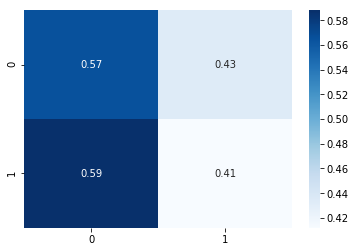

In [67]:
y_pred = myModel.predict_generator(data_gen_test)
pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(data_gen_test.classes,pred)
cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
sb.heatmap(cm,annot=True,cmap="Blues")

In [68]:
print(classification_report(data_gen_test.classes,pred))

              precision    recall  f1-score   support

           0       0.49      0.57      0.53       500
           1       0.49      0.41      0.45       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



In [69]:
myModel.evaluate_generator(data_gen_test,32)
#bestModel = tf.keras.models.load_model('FinalModel/CA_Xcep_Best_Run.h5')
#bestModel.summary()

[1.3727316707372665, 0.473]